# KENAR DESENDE PİRAMİT UYGULAMASI

KÜTÜPHANELER

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
import numpy as np
from kymatio import Scattering2D
from skimage import measure

Ön işleme aşamalarımızı uyguluyoruz VE piramit görüntü modelini uyguluyoruz

 (L1 Norm + Mean + Parlaklık(25))


Görüntü seviyelerinin boyutları:

Görüntü Seviye 0: (224, 224)

Görüntü Seviye 1: (112, 112)

Görüntü Seviye 2: (56, 56)

Görüntü Seviye 3: (28, 28)

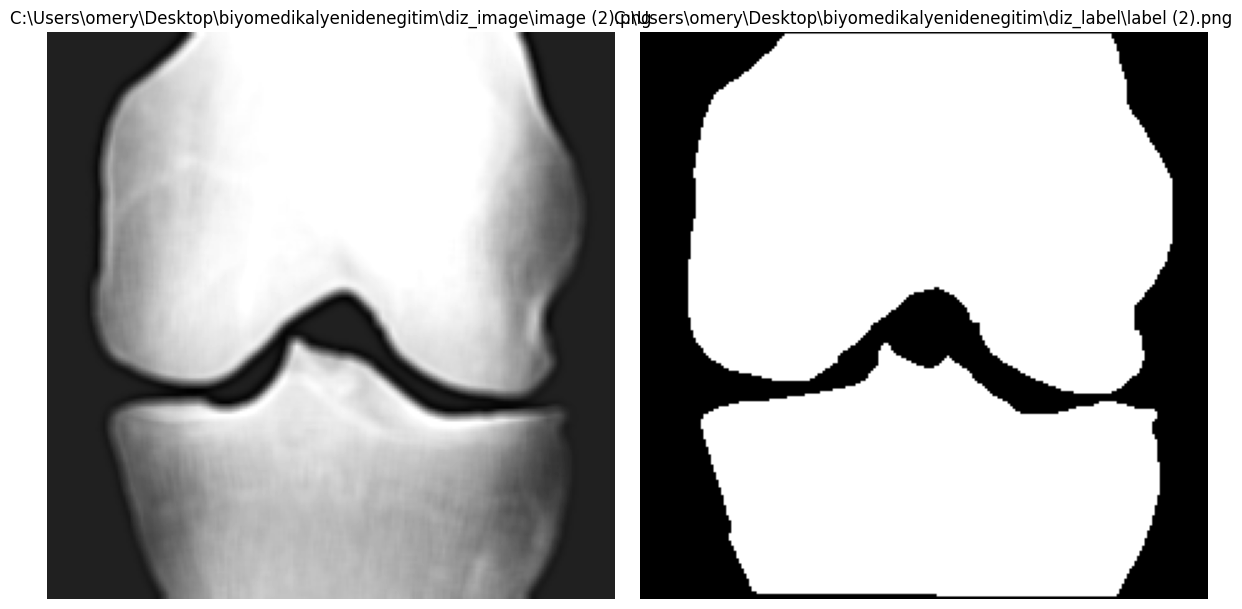

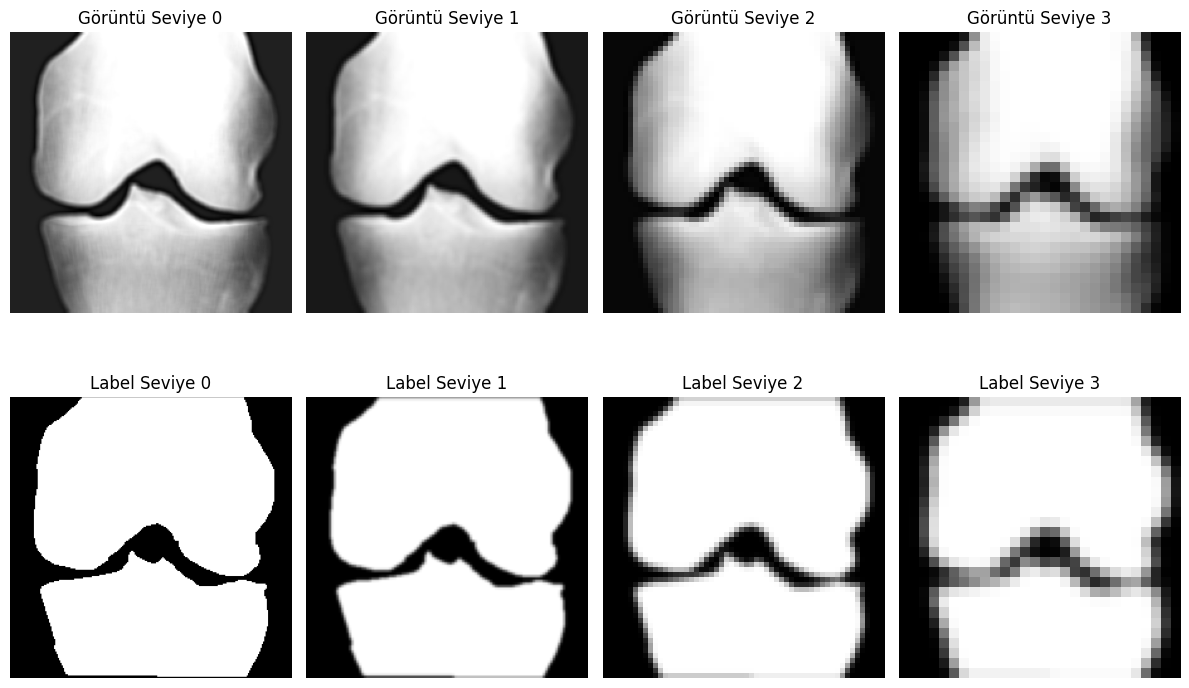


Görüntü seviyelerinin boyutları:
Görüntü Seviye 0: (224, 224)
Görüntü Seviye 1: (112, 112)
Görüntü Seviye 2: (56, 56)
Görüntü Seviye 3: (28, 28)

Label seviyelerinin boyutları:
Label Seviye 0: (224, 224)
Label Seviye 1: (112, 112)
Label Seviye 2: (56, 56)
Label Seviye 3: (28, 28)


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def ConvertAndNormalize(img, apply_preprocessing=True):
    # Eğer görüntü renkli ise gri tonlamaya çevir
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # I1 Norm Normalizasyonu
    normalized_image = img / 255.0  # Piksel değerlerini [0, 1] aralığına getir
    normalized_image = (normalized_image * 255).astype(np.uint8)  # [0, 255] aralığına geri çevir
    
    # Ön işleme işlemleri
    if apply_preprocessing:
        # Ortalama (Mean) Filtreleme
        def mean_filter(image, kernel_size=5):
            return cv2.blur(image, (kernel_size, kernel_size))  # Ortalama filtre uygula

        mean_filtered = mean_filter(normalized_image, kernel_size=5)

        # Parlaklık Artırma
        brightness_increase = 25  # Parlaklık artırma miktarı
        brightened_image = cv2.add(mean_filtered, np.full_like(mean_filtered, brightness_increase))
    
    # Normalize edilmiş görüntü döndürülür
    return brightened_image

def GetImageLabel(imgStr, labelStr, draw=False):
    img = cv2.imread(imgStr, cv2.IMREAD_GRAYSCALE); img = ConvertAndNormalize(img)
    label = cv2.imread(labelStr, cv2.IMREAD_GRAYSCALE)        
    if draw:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(imgStr)
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(label, cmap='gray')
        plt.title(labelStr)
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()  
    return img, label

# img ve label gorselleri al
img, label = GetImageLabel(
    r"C:\Users\omery\Desktop\biyomedikalyenidenegitim\diz_image\image (2).png",
    r"C:\Users\omery\Desktop\biyomedikalyenidenegitim\diz_label\label (2).png",
    draw=True
)

# Gauss piramidi oluşturma fonksiyonu
def create_gaussian_pyramid(image, levels=3):
    pyramid = [image]
    for _ in range(levels):
        image = cv2.pyrDown(image)  # Görüntüyü yarıya indir
        pyramid.append(image)
    return pyramid

# img ve label üzerinde Gauss piramidi oluştur
img_pyramid = create_gaussian_pyramid(img, levels=3)
label_pyramid = create_gaussian_pyramid(label, levels=3)

# Piramit seviyelerini ayrı değişkenlerde saklama
img_level_0, img_level_1, img_level_2, img_level_3 = img_pyramid
label_level_0, label_level_1, label_level_2, label_level_3 = label_pyramid

# Sonuçları görselleştirme
plt.figure(figsize=(12, 8))
for level, (pyr_img, pyr_label) in enumerate(zip(img_pyramid, label_pyramid)):
    plt.subplot(2, 4, level + 1)
    plt.imshow(pyr_img, cmap='gray')
    plt.title(f'Görüntü Seviye {level}')
    plt.axis('off')

    plt.subplot(2, 4, level + 5)
    plt.imshow(pyr_label, cmap='gray')
    plt.title(f'Label Seviye {level}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Piramit seviyelerinin boyutlarını yazdırma
print("\nGörüntü seviyelerinin boyutları:")
for level, pyr_image in enumerate(img_pyramid):
    print(f"Görüntü Seviye {level}: {pyr_image.shape}")

print("\nLabel seviyelerinin boyutları:")
for level, pyr_label in enumerate(label_pyramid):
    print(f"Label Seviye {level}: {pyr_label.shape}")


In [17]:
def Drawing(img, EdgePoints=None, EdgeLines=None, EdgePatchs=None, title=None, circle_radius=10):
    output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)    
       
    if EdgePoints is not None:         
        for point in EdgePoints:
            x, y = int(point[1]), int(point[0])  # x ve y koordinatları ters çevrilir
            cv2.circle(output_img, (x, y), circle_radius, (0, 0, 255), -1)  # Kırmızı daire   

    if EdgeLines is not None: 
        for Line in EdgeLines:
            start_point = Line["StartPointYX"]
            stop_point = Line["StopPointYX"]
            cv2.line(output_img, start_point[::-1], stop_point[::-1], color=(255, 255, 0), thickness=2)                                

    if EdgePatchs is not None: 
        # Img üzerine Patch çiz
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        color = (255, 0, 0)  
        thickness = 2
        for k, (x, y, PatchSize) in enumerate(EdgePatchs):  # (x, y, PatchSize) bekleniyor
            top_left = (x - PatchSize, y - PatchSize)
            bottom_right = (x + PatchSize, y + PatchSize)
            cv2.rectangle(output_img, top_left, bottom_right, (0, 0, 255), 2)
            cv2.putText(output_img, str(k), (x, y - 10), font, font_scale, color, thickness, cv2.LINE_AA)    

    # Görüntü boyutlarına göre figsize hesaplama
    height, width = img.shape[:2]
    aspect_ratio = width / height
    figsize = (15 * aspect_ratio, 15)  # Oranı koruyarak uygun bir ölçekleme

    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    if title is not None:
        plt.title(title, fontsize=30)
    plt.axis('off')
    plt.show()


AŞAMA AŞAMA İLERLEME YAPACAĞIZ. 

(Görüntü Seviye 1: (112, 112)) (sparsity_factor=10, circle_radius=3) 

( boundary ile noktalar aldık)

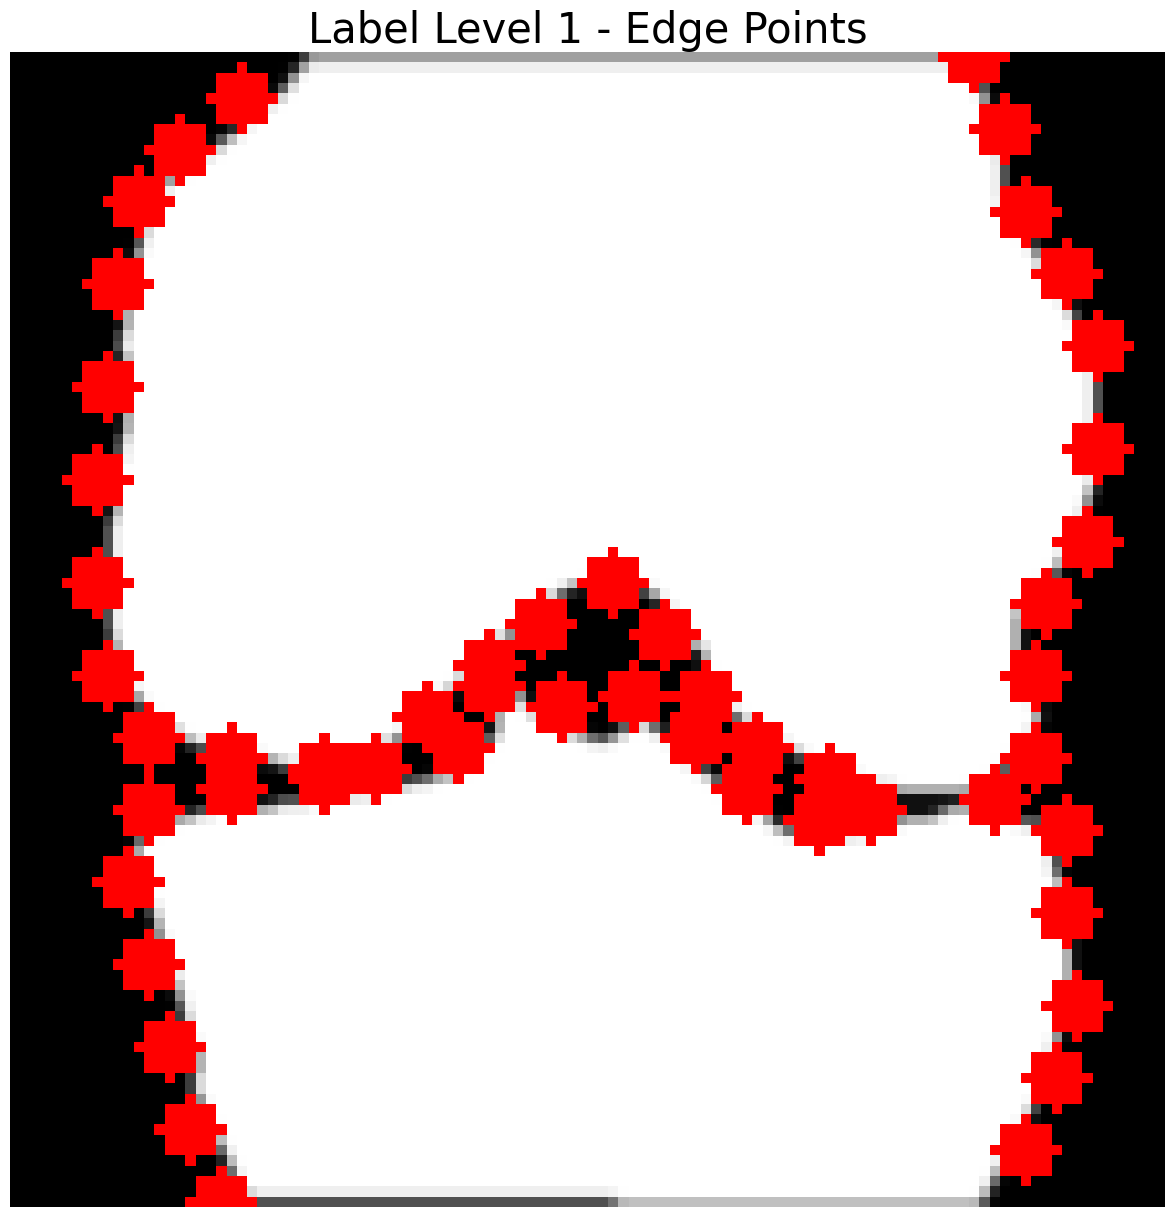

In [18]:
def GetLabelEdgePoints(img, sparsity_factor=1, circle_radius=10, draw=False, title=None):
    contours = measure.find_contours(img, level=0.5)
    # Tüm sınır piksellerini birleştir
    boundary_points = np.vstack(contours)
    
    # Sparsity factor ile seyrekleştirme
    if sparsity_factor > 1:
        boundary_points = boundary_points[::sparsity_factor]
        
    if draw:
        Drawing(img, EdgePoints=boundary_points, circle_radius=circle_radius, title=title)

    return boundary_points.astype(int)

# Kenar Gorsellerini Kodla
title = "Label Level 1 - Edge Points"
img_EdgePoints = GetLabelEdgePoints(label_level_1, sparsity_factor=10, circle_radius=3, draw=True, title=title)


In [19]:
def Drawing(img, EdgePoints=None, EdgeLines=None, EdgePatchs=None, title=None, circle_radius=5):
    import matplotlib.pyplot as plt
    import cv2
    # Çizim için görüntü kopyası
    img_draw = img.copy()

    # Noktaları çiz
    if EdgePoints is not None:
        for (y, x) in EdgePoints:
            cv2.circle(img_draw, (x, y), circle_radius, (255, 0, 0), -1)

    # Çizgileri çiz
    if EdgeLines is not None:
        for (x1, y1, x2, y2) in EdgeLines:
            cv2.line(img_draw, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Patch'leri çiz
    if EdgePatchs is not None:
        for k, (x, y, PatchSize, _) in enumerate(EdgePatchs):  # angle atlanıyor
            top_left = (x - PatchSize, y - PatchSize)
            bottom_right = (x + PatchSize, y + PatchSize)
            cv2.rectangle(img_draw, top_left, bottom_right, (0, 0, 255), 2)

    # Görselleştirme
    plt.figure(figsize=(8, 8))
    plt.imshow(img_draw, cmap='gray')
    plt.title(title if title else "Drawing")
    plt.axis('off')
    plt.show()


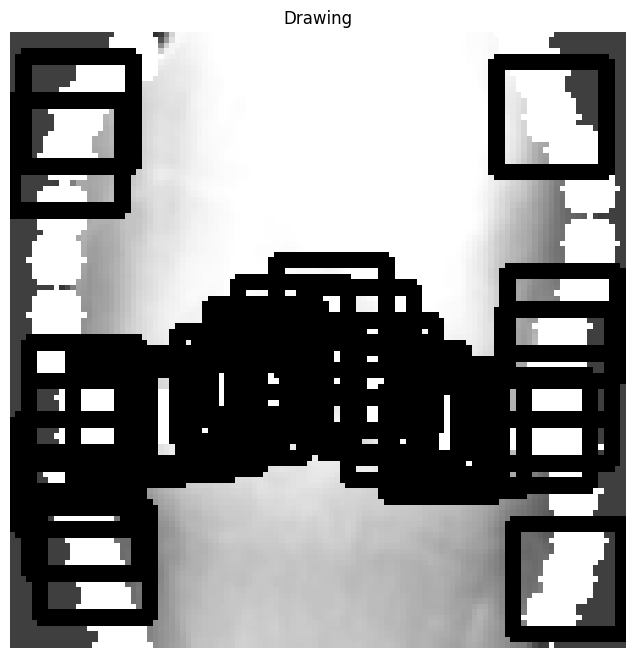

In [20]:
def GetEdgePatchs(img, EdgePoints, PatchSize=11, draw=True):
    EdgePatchs = []
    EdgePatchsInfo = []
    for i in range(len(EdgePoints)):
        # Çizginin başlangıç noktası
        y, x = EdgePoints[i]

        # Çizginin yönü
        prev_idx = (i - 1) % len(EdgePoints)
        next_idx = (i + 1) % len(EdgePoints)
        y1, x1 = EdgePoints[prev_idx]
        y2, x2 = EdgePoints[next_idx]
        dx = x2 - x1
        dy = y2 - y1
        if dx == 0 and dy == 0:
            continue  
        angle = math.atan2(-dx, dy)

        # Patch al
        center = (float(x), float(y))
        rotation_matrix = cv2.getRotationMatrix2D(center, np.degrees(angle), scale=1.0)
        rows, cols = img.shape
        rotated_image = cv2.warpAffine(img, rotation_matrix, (cols, rows), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        # Patch sınırlarını kontrol et
        y_start, y_end = y - PatchSize, y + PatchSize + 1
        x_start, x_end = x - PatchSize, x + PatchSize + 1

        if y_start < 0 or y_end > rows or x_start < 0 or x_end > cols:
            # Patch görüntü sınırlarının dışında, atla
            continue
                
        EdgePatch = rotated_image[y-PatchSize:y+PatchSize+1, x-PatchSize:x+PatchSize+1]

        EdgePatchs.append(EdgePatch)
        EdgePatchsInfo.append([x,y,PatchSize,np.degrees(angle)])
    
    if draw:
        Drawing(img, EdgePoints=EdgePoints, EdgePatchs = EdgePatchsInfo)        
        
    return EdgePatchs, EdgePatchsInfo

# img_EdgePoints --> img_EdgePatchs 
img_EdgePatchs, img_EdgePatchsInfo = GetEdgePatchs(img_level_1, img_EdgePoints, PatchSize=10, draw=True)  # M = 2*PatchSize + 1,  MxM = 101x101

In [21]:
# (Görüntü Seviye 1: (112, 112)) BU GÖRÜNTÜDEN BAŞARILI BİR ŞEKİLDE 11X11 48 PACH ALMAYI BAŞARDIK (PatchSize=5)

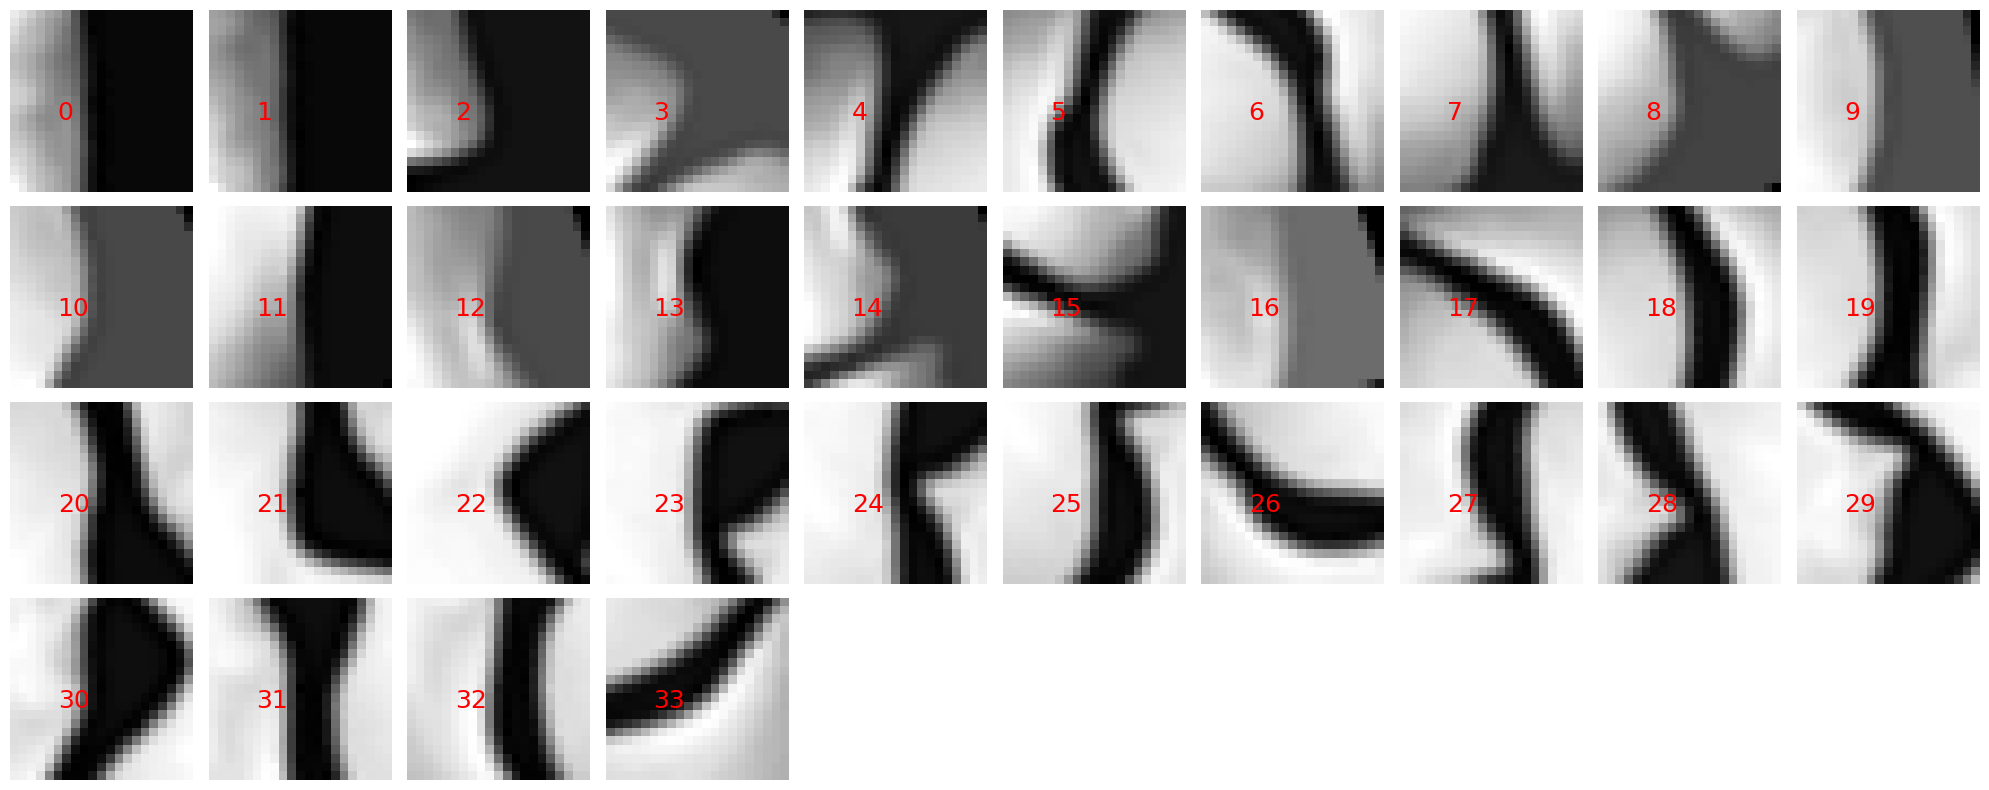

In [22]:
def DisplayPatches(EdgePatchs, max_cols=10):
    # Toplam patch sayısı
    num_patches = len(EdgePatchs)
    
    # Sütun sayısı (max_cols ile sınırlı)
    cols = min(max_cols, num_patches)
    
    # Satır sayısını hesapla
    rows = math.ceil(num_patches / cols)
    
    # Şekil oluşturma
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = np.array(axes).reshape(-1)  # Tek boyutlu diziye dönüştür
    
    for i, ax in enumerate(axes):
        if i < num_patches:
            ax.imshow(EdgePatchs[i], cmap='gray')
            ax.text(5, 10, str(i), color='red', fontsize=18, ha='left', va='top')
            ax.axis('off')
        else:
            ax.axis('off')  # Fazla eksenleri kapat
    
    plt.tight_layout()
    plt.show()


# img_EdgePatchs gorsellerini tek figurede gor (donmusmuyu kontrol et)
DisplayPatches(img_EdgePatchs)

Toplam 34 patch HOG ile kodlandı.

In [26]:
import cv2
import numpy as np
import os
import math

# HOG özelliklerini hesaplayan fonksiyon
def compute_hog_features(image, cell_size=(8, 8), block_size=(2, 2), nbins=9):
    """
    Verilen görüntü için HOG özelliklerini hesaplar.
    """
    hog = cv2.HOGDescriptor(
        _winSize=(image.shape[1] // cell_size[1] * cell_size[1], 
                  image.shape[0] // cell_size[0] * cell_size[0]),
        _blockSize=(block_size[1] * cell_size[1], block_size[0] * cell_size[0]),
        _blockStride=(cell_size[1], cell_size[0]),
        _cellSize=(cell_size[1], cell_size[0]),
        _nbins=nbins
    )
    features = hog.compute(image)
    return features.flatten()

# HOG özelliklerini ve koordinatlarını kaydeden fonksiyon
def save_hog_features_with_coords(patches, patch_info, output_path, cell_size=(8, 8), block_size=(2, 2), nbins=9):
    """
    Patch'lerin HOG özelliklerini ve koordinatlarını HDD'ye kaydeder.
    """
    all_features = []
    all_coords = []

    for i, (patch, info) in enumerate(zip(patches, patch_info)):
        features = compute_hog_features(patch, cell_size, block_size, nbins)
        all_features.append(features)
        all_coords.append(info)

        

    all_features = np.array(all_features)
    all_coords = np.array(all_coords)

    # Dosya yolu oluşturuluyor
    try:
        # Dizin yoksa oluşturuluyor
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
        # HOG özellikleri ve koordinatları kaydediliyor
        np.savez(output_path, features=all_features, coords=all_coords)
    except Exception as e:
        # Kaydetme sırasında oluşan hatayı yazdır
        print(f"Kaydetme sırasında hata oluştu: {e}")


# Görüntüyü ve kenar noktalarını al (img_level_1 değişkeni burada kullanılacak)
img = img_level_1  # img_level_1 burada kullanılıyor

# HOG özelliklerini kaydetme
output_file_with_coords = r"C:\Users\omery\Desktop\pyramid_1\hog_features_with_coords.npz"  # Masaüstü yolu

# Hata ayıklamak için görüntülerin ve patch'lerin doğru şekilde geçildiğini kontrol et
print(f"Patch sayısı: {len(img_EdgePatchs)}")
save_hog_features_with_coords(img_EdgePatchs, img_EdgePatchsInfo, output_file_with_coords)

# Sonuç olarak toplam kaç patch kodlandığını yazdır
print(f"Toplam {len(img_EdgePatchs)} patch , Tek bir HOG vektörü ile kodlandı.")


Patch sayısı: 34
Toplam 34 patch , Tek bir HOG vektörü ile kodlandı.


----

# TEST AŞAMASI

SEVİYE 1 TEST AŞAMASI

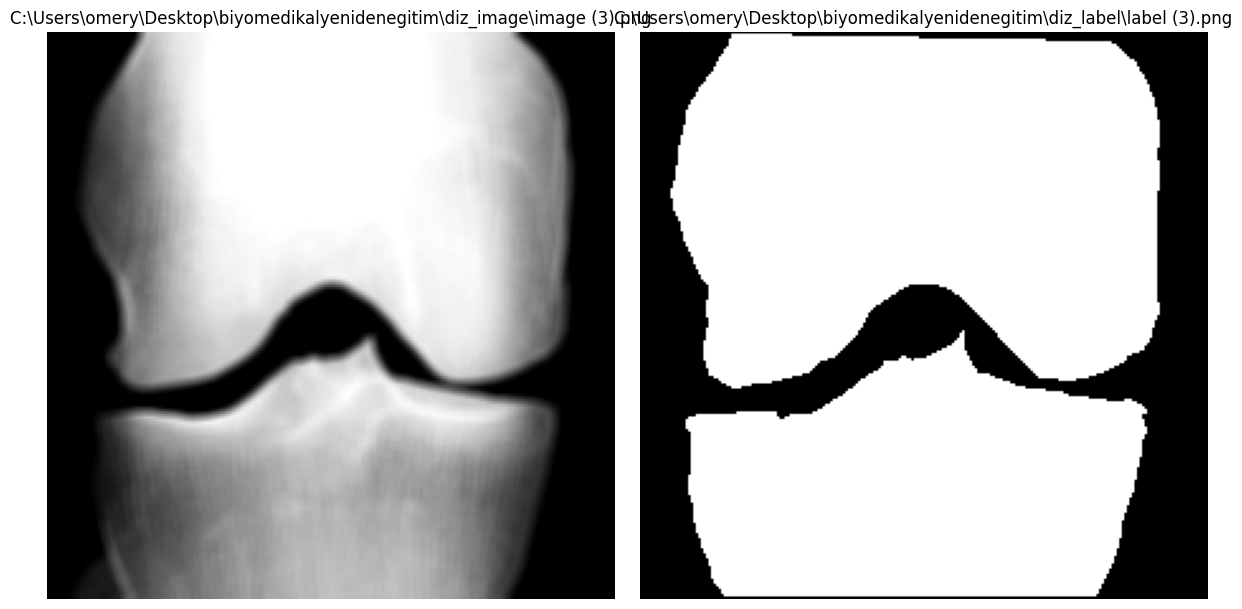

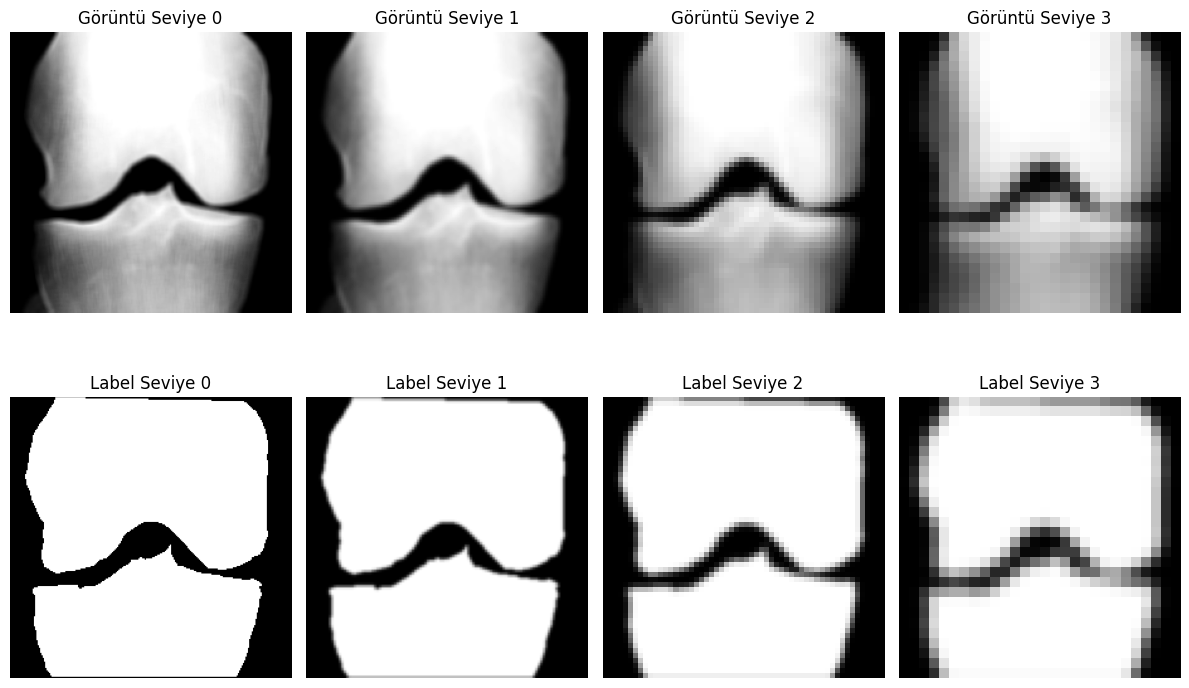


Görüntü seviyelerinin boyutları:
Görüntü Seviye 0: (224, 224)
Görüntü Seviye 1: (112, 112)
Görüntü Seviye 2: (56, 56)
Görüntü Seviye 3: (28, 28)

Label seviyelerinin boyutları:
Label Seviye 0: (224, 224)
Label Seviye 1: (112, 112)
Label Seviye 2: (56, 56)
Label Seviye 3: (28, 28)


In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def ConvertAndNormalize(img, apply_preprocessing=True):
    # Eğer görüntü renkli ise gri tonlamaya çevir
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # I1 Norm Normalizasyonu
    normalized_image = img / 255.0  # Piksel değerlerini [0, 1] aralığına getir
    normalized_image = (normalized_image * 255).astype(np.uint8)  # [0, 255] aralığına geri çevir
    
    # Ön işleme işlemleri
    if apply_preprocessing:
        # Ortalama (Mean) Filtreleme
        def mean_filter(image, kernel_size=5):
            return cv2.blur(image, (kernel_size, kernel_size))  # Ortalama filtre uygula

        mean_filtered = mean_filter(normalized_image, kernel_size=5)

        # Parlaklık Artırma
        brightness_increase = 20  # Parlaklık artırma miktarı
        brightened_image = cv2.add(mean_filtered, np.full_like(mean_filtered, brightness_increase))
    
    # Normalize edilmiş görüntü döndürülür
    return brightened_image

def GetImageLabel(imgStr, labelStr, draw=False):
    img = cv2.imread(imgStr, cv2.IMREAD_GRAYSCALE); img = ConvertAndNormalize(img)
    label = cv2.imread(labelStr, cv2.IMREAD_GRAYSCALE)        
    if draw:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(imgStr)
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(label, cmap='gray')
        plt.title(labelStr)
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()  
    return img, label

# img ve label gorselleri al
img, label = GetImageLabel(
    r"C:\Users\omery\Desktop\biyomedikalyenidenegitim\diz_image\image (3).png",
    r"C:\Users\omery\Desktop\biyomedikalyenidenegitim\diz_label\label (3).png",
    draw=True
)

# Gauss piramidi oluşturma fonksiyonu
def create_gaussian_pyramid(image, levels=3):
    pyramid = [image]
    for _ in range(levels):
        image = cv2.pyrDown(image)  # Görüntüyü yarıya indir
        pyramid.append(image)
    return pyramid

# img ve label üzerinde Gauss piramidi oluştur
img_pyramid = create_gaussian_pyramid(img, levels=3)
label_pyramid = create_gaussian_pyramid(label, levels=3)

# Piramit seviyelerini ayrı değişkenlerde saklama
test_img_level_0, test_img_level_1, test_img_level_2, test_img_level_3 = img_pyramid
test_label_level_0, test_label_level_1, test_label_level_2, test_label_level_3 = label_pyramid

# Sonuçları görselleştirme
plt.figure(figsize=(12, 8))
for level, (pyr_img, pyr_label) in enumerate(zip(img_pyramid, label_pyramid)):
    plt.subplot(2, 4, level + 1)
    plt.imshow(pyr_img, cmap='gray')
    plt.title(f'Görüntü Seviye {level}')
    plt.axis('off')

    plt.subplot(2, 4, level + 5)
    plt.imshow(pyr_label, cmap='gray')
    plt.title(f'Label Seviye {level}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Piramit seviyelerinin boyutlarını yazdırma
print("\nGörüntü seviyelerinin boyutları:")
for level, pyr_image in enumerate(img_pyramid):
    print(f"Görüntü Seviye {level}: {pyr_image.shape}")

print("\nLabel seviyelerinin boyutları:")
for level, pyr_label in enumerate(label_pyramid):
    print(f"Label Seviye {level}: {pyr_label.shape}")


test görüntümüzden cany ile noktalar alıyoruz

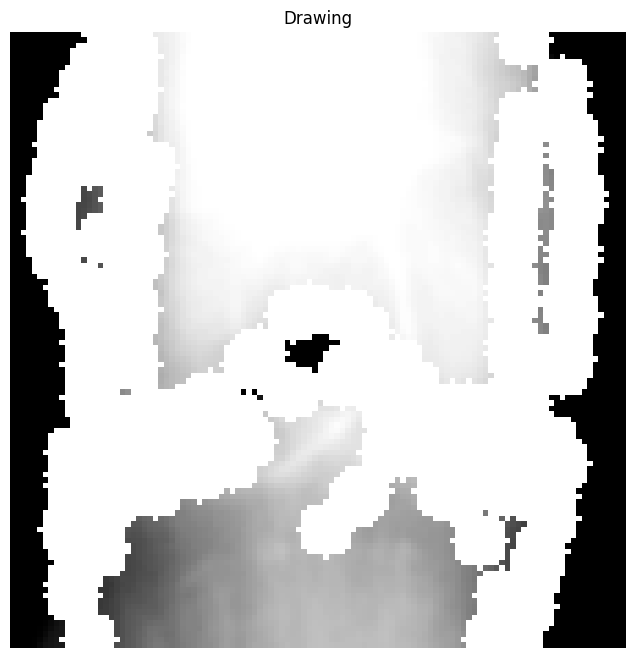

In [28]:
def GetCannyEdgePoints(img, sparsity_factor=1, draw=False):
    blurimg = cv2.GaussianBlur(img, (5, 5), 0)
    edges = cv2.Canny(blurimg, 25, 75)
    CannyEdgePoints, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    EdgePoints = []
    for ObjPoints in CannyEdgePoints:
        EdgePoints = EdgePoints + [(point[0][1], point[0][0]) for i, point in enumerate(ObjPoints) if i % sparsity_factor == 0]

    if draw:
        Drawing(img, EdgePoints=EdgePoints)

    return EdgePoints

test_img_EdgePoints = GetCannyEdgePoints(test_img_level_1, sparsity_factor=10, draw=True)   # EdgePoints --> [p,2] --> (y,x)

Noktalardan 21x21 pachler alıyoruz. (PatchSize=10)

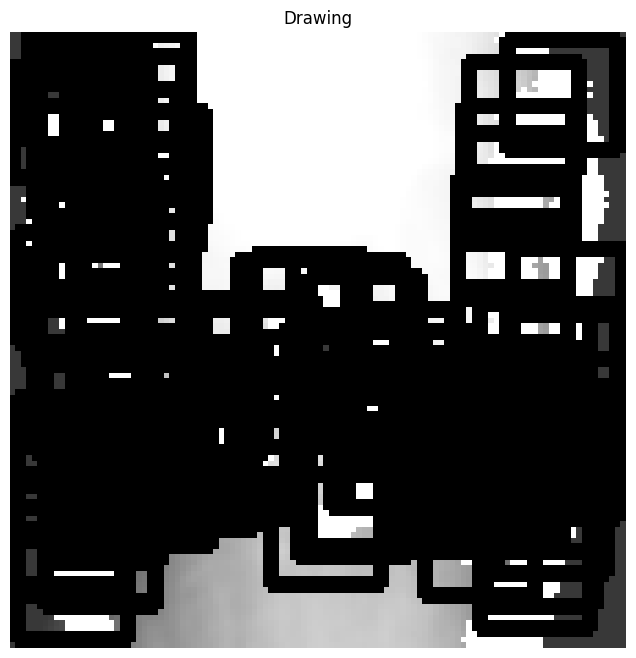

In [29]:
def GetEdgePatchs(img, EdgePoints, PatchSize=11, draw=True):
    EdgePatchs = []
    EdgePatchsInfo = []
    for i in range(len(EdgePoints)):
        # Çizginin başlangıç noktası
        y, x = EdgePoints[i]

        # Çizginin yönü
        prev_idx = (i - 1) % len(EdgePoints)
        next_idx = (i + 1) % len(EdgePoints)
        y1, x1 = EdgePoints[prev_idx]
        y2, x2 = EdgePoints[next_idx]
        dx = x2 - x1
        dy = y2 - y1
        if dx == 0 and dy == 0:
            continue  
        angle = math.atan2(-dx, dy)

        # Patch al
        center = (float(x), float(y))
        rotation_matrix = cv2.getRotationMatrix2D(center, np.degrees(angle), scale=1.0)
        rows, cols = img.shape
        rotated_image = cv2.warpAffine(img, rotation_matrix, (cols, rows), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)
        # Patch sınırlarını kontrol et
        y_start, y_end = y - PatchSize, y + PatchSize + 1
        x_start, x_end = x - PatchSize, x + PatchSize + 1

        if y_start < 0 or y_end > rows or x_start < 0 or x_end > cols:
            # Patch görüntü sınırlarının dışında, atla
            continue
                
        EdgePatch = rotated_image[y-PatchSize:y+PatchSize+1, x-PatchSize:x+PatchSize+1]

        EdgePatchs.append(EdgePatch)
        EdgePatchsInfo.append([x,y,PatchSize,np.degrees(angle)])
    
    if draw:
        Drawing(img, EdgePoints=EdgePoints, EdgePatchs = EdgePatchsInfo)        
        
    return EdgePatchs, EdgePatchsInfo


test_img_EdgePatchs, test_img_EdgePatchsInfo = GetEdgePatchs(test_img_level_1, test_img_EdgePoints, PatchSize=10, draw=True)

Toplam 118 patch HOG ile kodlandı.

In [31]:
import cv2
import numpy as np
import os
import math

# HOG özelliklerini hesaplayan fonksiyon
def compute_hog_features(image, cell_size=(8, 8), block_size=(2, 2), nbins=9):
    """
    Verilen görüntü için HOG özelliklerini hesaplar.
    """
    hog = cv2.HOGDescriptor(
        _winSize=(image.shape[1] // cell_size[1] * cell_size[1], 
                  image.shape[0] // cell_size[0] * cell_size[0]),
        _blockSize=(block_size[1] * cell_size[1], block_size[0] * cell_size[0]),
        _blockStride=(cell_size[1], cell_size[0]),
        _cellSize=(cell_size[1], cell_size[0]),
        _nbins=nbins
    )
    features = hog.compute(image)
    return features.flatten()

# HOG özelliklerini ve koordinatlarını kaydeden fonksiyon
def save_hog_features_with_coords(patches, patch_info, output_path, cell_size=(8, 8), block_size=(2, 2), nbins=9):
    """
    Patch'lerin HOG özelliklerini ve koordinatlarını HDD'ye kaydeder.
    """
    all_features = []
    all_coords = []

    for i, (patch, info) in enumerate(zip(patches, patch_info)):
        features = compute_hog_features(patch, cell_size, block_size, nbins)
        all_features.append(features)
        all_coords.append(info)

    all_features = np.array(all_features)
    all_coords = np.array(all_coords)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    np.savez(output_path, features=all_features, coords=all_coords)
    print(f"HOG özellikleri ve koordinatlar kaydedildi: {output_path}")

# Görüntüyü ve kenar noktalarını al (img_level_1 değişkeni burada kullanılacak)
img = img_level_1  # img_level_1 burada kullanılıyor

# HOG özelliklerini kaydetme
output_file_with_coords = r"C:\Users\omery\Desktop\pyramid_1\test_image3_hog_features_with_coords.npz"
save_hog_features_with_coords(test_img_EdgePatchs, test_img_EdgePatchsInfo, output_file_with_coords)

# Sonuç olarak toplam kaç patch kodlandığını yazdır
print(f"Toplam {len(test_img_EdgePatchs)} patch , Tek bir HOG vektörü ile kodlandı.")


HOG özellikleri ve koordinatlar kaydedildi: C:\Users\omery\Desktop\pyramid_1\test_image3_hog_features_with_coords.npz
Toplam 118 patch , Tek bir HOG vektörü ile kodlandı.


seviye 1 cross kolerasyon ile eşleşen noktalar. 

(0.30 ve üzeri korelasyona sahip eşleşme sayısı 2447)

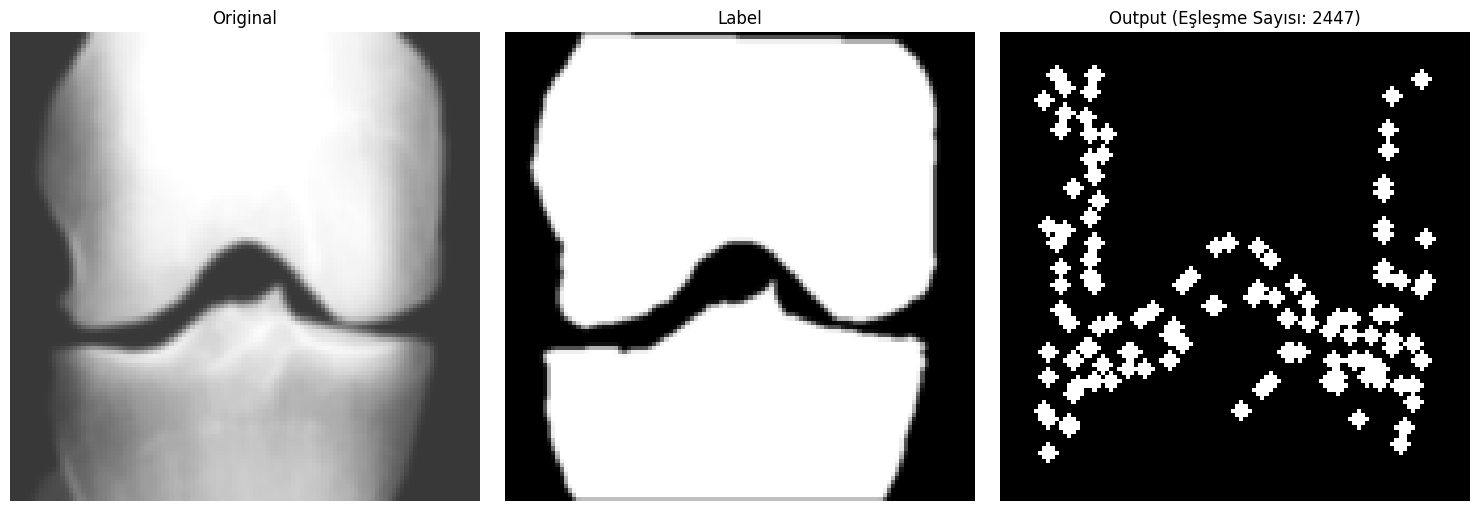

In [32]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Optimize edilmiş çapraz korelasyon fonksiyonu
def compute_cross_correlation_optimized(vectors1, vectors2):
    return 1 - cdist(vectors1, vectors2, metric='correlation')  # Korelasyon mesafesi

# HDD'deki referans HOG vektörlerini yükleme
stored_hog_vectors = np.load(r"C:\Users\omery\Desktop\pyramid_1\hog_features_with_coords.npz")['features']

# Test ve etiket görüntülerini daha önceki kodlardan yükleme
test_image = test_img_level_1
label_image = test_label_level_1

# Test HOG vektörlerini ve koordinatlarını yükleme
test_hog_data = np.load(r"C:\Users\omery\Desktop\pyramid_1\test_image3_hog_features_with_coords.npz")
test_hog_vectors = test_hog_data['features']
test_coords = test_hog_data['coords']

# Korelasyon işlemleri ve görselleştirme
plt.figure(figsize=(15, 5))
output_images = []  # Sonuç görsellerini tutmak için bir liste oluştur

# Çapraz korelasyonu hızlı hesaplama
correlations_matrix = compute_cross_correlation_optimized(test_hog_vectors, stored_hog_vectors)
threshold = 0.30
high_correlation_indices = np.argwhere(correlations_matrix >= threshold)

# Yüksek korelasyon eşleşmelerini işleme
output_img = np.zeros_like(test_image)  # Siyah bir görüntü oluşturma
matching_coords_count = 0
for test_idx, stored_idx in high_correlation_indices:
    coord = test_coords[test_idx]
    x, y = int(coord[0]), int(coord[1])
    cv2.circle(output_img, (x, y), 2, (255, 255, 255), -1)
    matching_coords_count += 1

# Orijinal görüntüler ve sonuç görselleştirme
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(label_image, cv2.COLOR_BGR2RGB))
plt.title("Label")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.title(f"Output (Eşleşme Sayısı: {matching_coords_count})")
plt.axis('off')

plt.tight_layout()
plt.show()

# Sonuç görsellerini bir değişkende tutma
final_output_image = output_img  # Son görseli tutan değişken


MORFOLOJİK OPERASYONLAR

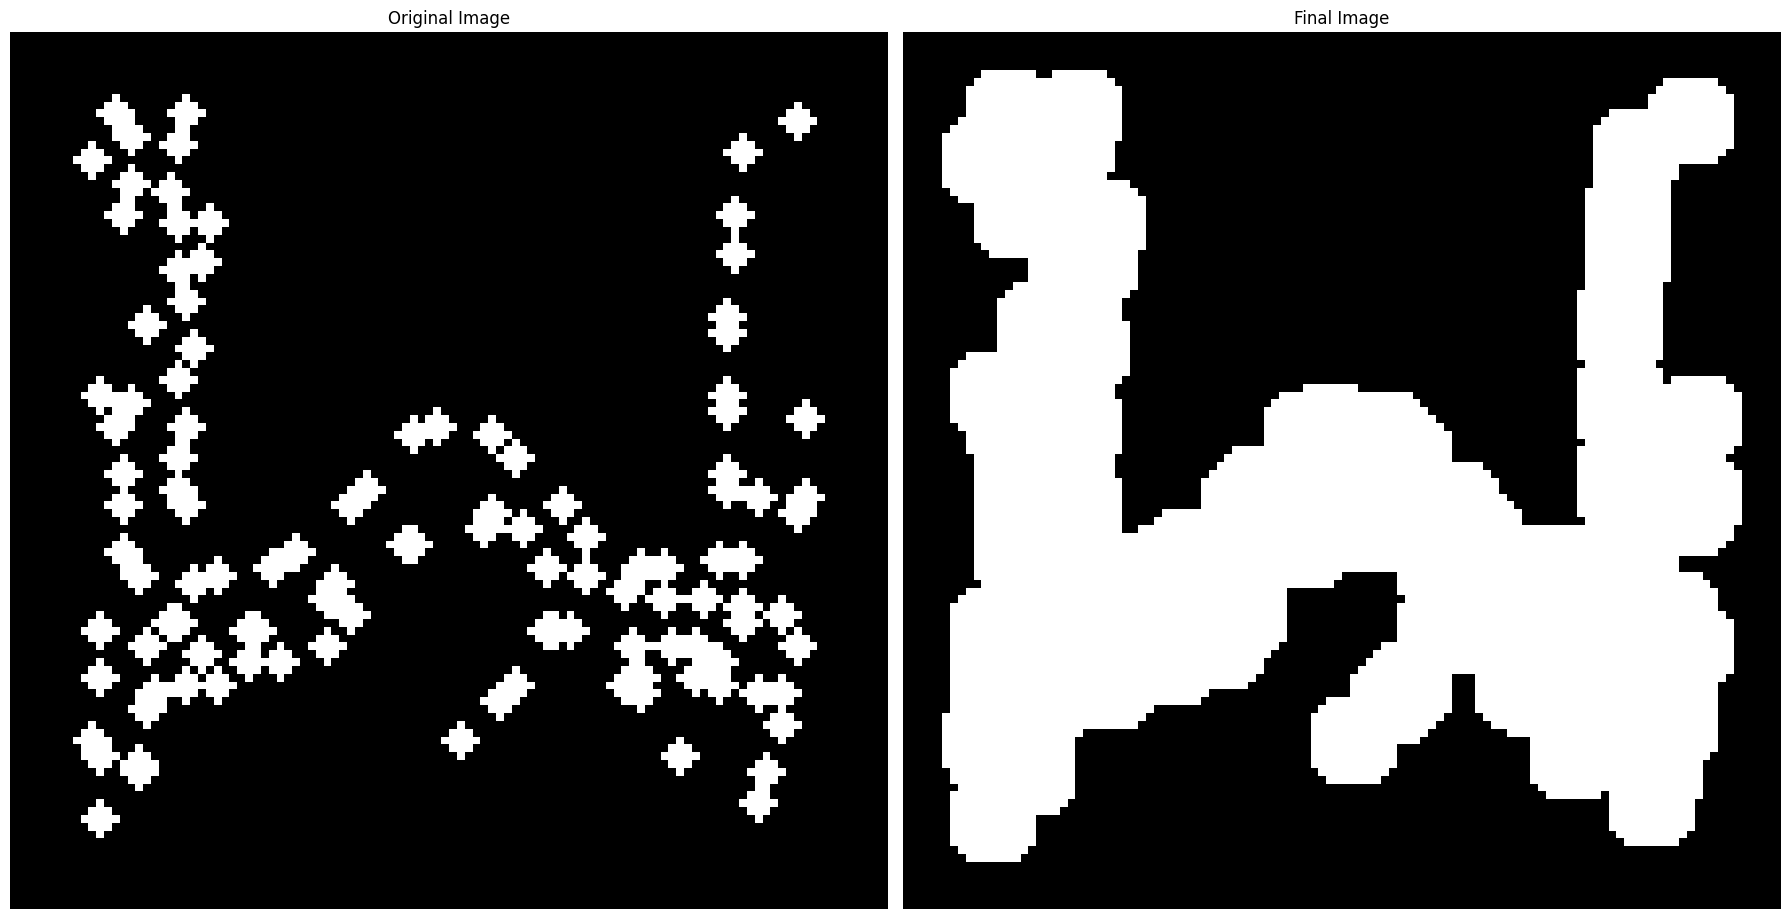

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Görüntüyü yükleme ve gri tonlamaya dönüştürme
if isinstance(final_output_image, np.ndarray):
    if len(final_output_image.shape) == 3:  # Eğer görüntü renkli ise gri tonlamaya dönüştür
        image = cv2.cvtColor(final_output_image, cv2.COLOR_BGR2GRAY)
    else:
        image = final_output_image  # Zaten gri tonlamalı
else:
    image = cv2.imread(final_output_image, cv2.IMREAD_GRAYSCALE)

if image is None:
    raise ValueError("Görüntü yüklenemedi. Lütfen doğru yolu kontrol edin veya geçerli bir NumPy dizisi kullanın.")

# --- Ayarlanabilir Eşik Değerleri ---
threshold_value_initial = 20  # İlk eşik değeri (örneğin kenar tespiti için)
blur_kernel_size = 5          # Bulanıklaştırma için kernel boyutu
morph_kernel_size = 3         # Morfolojik işlemler için kernel boyutu
dilate_iterations = 1         # Dilatasyon iterasyon sayısı
distance_threshold_value = 10 # Distance transform için eşik değeri

# --- Kenarları Tespit Etme ---
_, binary_image = cv2.threshold(image, threshold_value_initial, 255, cv2.THRESH_BINARY)

# --- Bulanıklaştırma ---
blurred_image = cv2.GaussianBlur(binary_image, (blur_kernel_size, blur_kernel_size), 0)

# --- Morfolojik İşlemler: Closing ---
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (morph_kernel_size, morph_kernel_size))
morphed_image = cv2.morphologyEx(blurred_image, cv2.MORPH_CLOSE, kernel)

# --- Dilatasyon ile Noktaları Birleştirme ---
dilated_image = cv2.dilate(morphed_image, kernel, iterations=dilate_iterations)

# --- Distance Transform ---
distance_transform = cv2.distanceTransform(dilated_image, cv2.DIST_L2, 5)
_, distance_thresholded = cv2.threshold(distance_transform, distance_threshold_value, 255, cv2.THRESH_BINARY)
distance_thresholded = distance_thresholded.astype(np.uint8)

# --- Bağlantılı Bileşen Analizi ---
num_labels, labels_im = cv2.connectedComponents(distance_thresholded)

# --- Konturları Bulma ve Poligon Oluşturma ---
contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
polygon_image = np.zeros_like(dilated_image)

for contour in contours:
    # Konturların içini beyaz yap (poligon şekli)
    cv2.fillPoly(polygon_image, [contour], 255)

# Poligon içindeki alanları beyaz yap
final_image = cv2.bitwise_or(dilated_image, polygon_image)

# --- Sonuçları Görselleştirme ---
plt.figure(figsize=(18, 12))

# Orijinal Görüntü
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')



# Final Görüntü
plt.subplot(1, 2, 2)
plt.imshow(final_image, cmap='gray')
plt.title("Final Image")
plt.axis('off')

plt.tight_layout()
plt.show()



# IoU HESAPLAMA

Final Image IoU: 0.3676


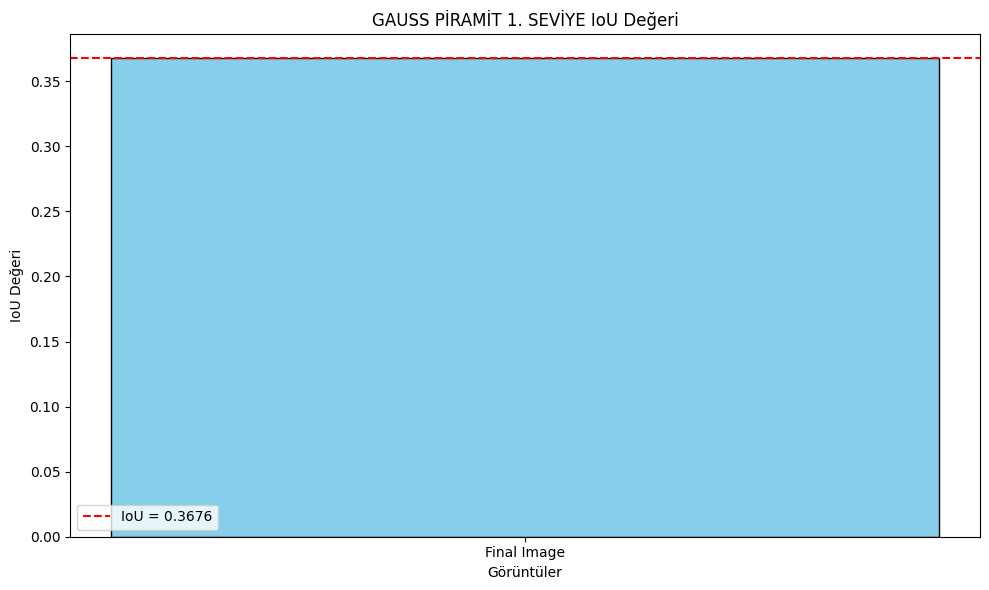

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# IoU hesaplama fonksiyonu
def calculate_iou(predicted_image, label_image):
    # İkili görüntüye dönüştürme (thresholding)
    _, pred_binary = cv2.threshold(predicted_image, 127, 255, cv2.THRESH_BINARY)
    _, label_binary = cv2.threshold(label_image, 127, 255, cv2.THRESH_BINARY)
    
    # Kesişim ve birleşim
    intersection = np.logical_and(pred_binary > 0, label_binary > 0).sum()
    union = np.logical_or(pred_binary > 0, label_binary > 0).sum()
    
    # IoU hesaplama
    iou = intersection / union if union != 0 else 0
    return iou

# final_image'i kontrol etme
if final_image is None:
    print("Final görüntüsü yüklenemedi!")
else:
    # Eğer final_image zaten gri tonlamalıysa, doğrudan eşikleme yapabilirsiniz
    _, final_binary = cv2.threshold(final_image, 127, 255, cv2.THRESH_BINARY)

# Etiket görüntüsünü yükleme ve kontrol etme
label_image = test_label_level_1  # Etiket görüntüsünün yolu buraya girilmeli
if label_image is None:
    print("Etiket görüntüsü yüklenemedi!")
else:
    # Etiket görüntüsünü ikili hale getirme
    _, label_binary = cv2.threshold(label_image, 127, 255, cv2.THRESH_BINARY)


# IoU hesaplama
if final_image is not None and label_image is not None:
    iou = calculate_iou(final_binary, label_binary)
    print(f"Final Image IoU: {iou:.4f}")

    # IoU Grafik Çıktısı
    plt.figure(figsize=(10, 6))
    plt.bar(["Final Image"], [iou], color='skyblue', edgecolor='black')
    plt.axhline(iou, color='red', linestyle='--', label=f"IoU = {iou:.4f}")
    plt.xlabel('Görüntüler')
    plt.ylabel('IoU Değeri')
    plt.title('GAUSS PİRAMİT 1. SEVİYE IoU Değeri')
    plt.legend()
    plt.tight_layout()
    plt.show()


------

Görüntü seviyelerinin boyutları:

Görüntü Seviye 0: (224, 224)

Görüntü Seviye 1: (112, 112)

Görüntü Seviye 2: (56, 56)

Görüntü Seviye 3: (28, 28)

Görüntü Seviye 2: (56, 56)

2.seviyede image görüntümüz 56x56 lık boyutlara düştüğü için 2. ve 3. aşama piramit görsellerini kodlayamadık. 

Görsellerimiz çok küçük olduğundan 1. seviyede uyguladığımız kodlar hata veriyor.

pachsize:5 alırsak 11x11 lik pachler den yalnızca 2 veya 3 tanesi alınıyor ve pachsize:5 de kodlar hata veriyor

-----